# University of Michigan, NA/EECS 568, ROB 530
# Mobile Robotics: Methods & Algorithms, Winter 2025

## Homework 5 $-$ SLAM

- **See the course Canvas for syllabus, due dates, and homework and grading policies.**
- This course utilizes an autograder to evaluate homework. For each of the five problems, carefully read the submission instructions and complete the TODOs in the corresponding Python script. Once you have finished coding, upload all scripts to GradeScope for automatic assessment and grading. Please note, the autograder retains only the latest score, not the highest.
- You are encouraged to talk at the conceptual level with other students, but you must complete all work individually and may not share any non-trivial code or solution steps. See the syllabus for the full collaboration policy.
- For each problem, the autograder will check the **return value** of the function you implement. Additionally, the variables are printed in this notebook for you to review.

## Overview

In this homework, you're going to solve the pose graph SLAM problem
using the GTSAM library. If you are not familiar with GTSAM, a detailed
tutorial is on their website: <https://gtsam.org/tutorials/intro.html>.
While GTSAM is developed using C++, it also provides MATLAB and
Python wrapper. In this assignment, we are going to use the Python wrapper.

After you successfully install GTSAM, write a function to read
[G2O files](https://github.com/RainerKuemmerle/g2o/wiki/File-Format) 
and solve the graph optimization problem for both 2D and 3D cases
using GTSAM. In this assignment, we use datasets provided at
<https://lucacarlone.mit.edu/datasets/>.


## GTSAM Installation Guide

Below we provide an guide for installing the Python wrapper of GTSAM library.

1. Method 1 (preferred): Using `conda`:
    ```sh
    conda create -n na568 python==3.9 numpy==1.26.4 conda-forge::gtsam==4.2.0 conda-forge::matplotlib==3.8.3 conda-forge::jupyterlab scipy
    ```
    Run this to activate the environment:
    ```sh
    conda activate na568
    ```
2.  Method 2: Using `pip`. According to [pypi](https://pypi.org/project/gtsam/4.2/#files) only Linux and MacOS is supported.
    ```sh
    pip install gtsam==4.2.0
    ```

3. Method 3: Build from source. Follow the instructions
    [here](https://github.com/borglab/gtsam/blob/develop/python/README.md)
    to install. Below are some guides on how to install the Python
    wrapper.

    -   After you successfully clone the repository and create the build
        folder, you'll have to first go into the cython folder and
        install the required dependencies.
        `pip install -r <gtsam_folder>/python/requirements.txt`

    -   Then you'll have to do cmake differently by specifying the the
        Python version you want to use and enable Python wrapper:
        `cmake .. -DGTSAM_BUILD_PYTHON=1 -DGTSAM_PYTHON_VERSION=<your_python_version>`

    -   Compile the files in build (-j means using multi-thread. 10 is
        the number of threads you want to use)
        `make -j10`

    -   Install it to your machine
        `sudo make python-install`

You may refer to some python gtsam examples
[here](https://github.com/borglab/gtsam/tree/develop/python/gtsam/examples).

## Read the Following FAQ before Getting Started!

1.  Q: Which version of GTSAM should I use?
    
    A: This homework is built with GTSAM 4.2.0 and the autograder will
    use the same version to test your code. We noticed that GTSAM has
    changed its Python interface multiple times before. It is recommended
    to use this version in order to avoid error.

2.  Q: The logic of my code is correct but I can't get the expected result.

    A: We noticed some students use the code shown below
    experienced imperfect plot caused by precision issue.
    `gtsam.Pose2([x,y,theta])`.
    
    Instead, the correct construction of the `Pose2` is
    `gtsam.Pose2(x,y,theta)`.
    
    You should follow the same pattern when constructing `Pose3`.

3.  Q: How can I resolve the issues when installing the libraries?
    
    A: Google your error information first, and try to find the answer
    on the GitHub issues page and piazza. If it still exists, please
    send a new piazza post with your system information, the version of
    your coding language, and your error information.

4.  Q: I'm a Python user, but GTSAM only has C++ Doxygen documentation.
    How do I know how to implement the algorithms?
    
    A: Great question! Looking at [GTSAM python
    examples](https://github.com/gtbook/gtsam-examples) from Github
    would be sufficient for the Homework! Also, if you wish to look into
    detailed function explanation and usage, unfortunately, you have to
    refer to [C++
    documentation](https://gtsam.org/doxygen/4.0.0/a02687.html).

5.  Q: Since GTSAM is available in C++/Python/MATLAB, which language
    should I use for other GTSAM projects?
    
    A: Generating plots is easier in Python/MATLAB, while
    C++ has better documentation of GTSAM. Mixing these is also
    acceptable, you can save your optimization result from C++ and write
    a script to visualize it in Python/MATLAB. Also, check this nice
    library for plotting in C++
    <https://github.com/lava/matplotlib-cpp>.

    In practice, when the computational time matters in the application,
    which is mostly true for robotics projects if we want to deploy the
    algorithms on the robot eventually, C++ is preferred among the three
    languages. Writing GTSAM in C++ is a more common practice for real
    applications.

In [27]:
# run this block to enable autoreload of modules
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from pose_graph_slam import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



## 2D Graph SLAM (50 points)


#### Submission
Please fill the **TODO**s in the function contained in **pose_graph_slam.py** and submit the file to gradescope.

#### Instructions

1. Implement `read_g2o_2d` function (10 points)
2. Implement `gn_2d` function (20 points)
3. Implement `isam_2d` function (20 points)

Your code is evaluated at each step using test input independently. Specifically, during steps 2 and 3, the autograder will use the correct `read_g2o_2d` function to test your code. For example, even if the `read_g2o_2d` function from step 1 is incorrect, implementing `gn_2d` correctly in step 2 can still earn you full credits.

### Task 1A. Reading 2D G2O (10 pts)

Write a function to read [2D Intel dataset](https://www.dropbox.com/s/vcz8cag7bo0zlaj/input_INTEL_g2o.g2o?dl=0) from G2O format and output poses and edges. The file used in task 1 is`data/input_INTEL_g2o.g2o`. These poses and edges are used in later problems.

For 2D data, the pose in G2O format is `[VERTEX_SE2 i x y theta]`
and the edge in G2O format is
`[EDGE_SE2 i j x y theta info(x, y, theta)]`, where
`info(x, y, theta)` is a 1 $\times$ 6 vector
$[q_{11} \; q_{12} \; q_{13} \; q_{22} \; q_{23} \; q_{33}]$ where
the elements are the upper-triangle matrix of the 3 $\times$ 3
information matrix $\Omega = \begin{bmatrix} 
q_{11} & q_{12} & q_{13}\\
q_{12} & q_{22} & q_{23}\\
q_{13} & q_{23} & q_{33}
\end{bmatrix}$. By inverting this information matrix, you can obtain
the covariance matrix for the noise model.

You may look into detail in the [g2o repository](https://github.com/RainerKuemmerle/g2o/wiki/File-Format-SLAM-2D).

In [28]:
data = read_g2o_2d('data/input_INTEL_g2o.g2o')

p = data['poses']
e = data['edges']


print('First 3 pose in the dataset:')
for i in range(3):
    print(f'pose {i}: {p[i]}')

print('\nFirst 3 edges in the dataset:')
for i in range(3):
    print(f'edge {i}: {e[i]}')


First 3 pose in the dataset:
pose 0: Pose2(id=0, x=0.0, y=0.0, theta=0.0)
pose 1: Pose2(id=1, x=0.0, y=0.0, theta=-0.000642)
pose 2: Pose2(id=2, x=0.0, y=0.0, theta=-0.00118)

First 3 edges in the dataset:
edge 0: Edge2(id1=0, id2=1, x=0.0, y=0.0, theta=-0.000642,
info=
11.11 -0.25 0.00
-0.25 400.00 0.00
0.00 0.00 2496.79)

edge 1: Edge2(id1=1, id2=2, x=0.0, y=0.0, theta=-0.000538,
info=
11.11 -0.21 0.00
-0.21 400.00 0.00
0.00 0.00 2497.31)

edge 2: Edge2(id1=2, id2=3, x=0.011003, y=-0.000962, theta=-0.002382,
info=
5898.29 69216.36 0.00
69216.36 813797.50 0.00
0.00 0.00 2488.13)



### Task 1B. Batch Solution (20 pts)

A batch solution means when we
construct the entire graph and solve it at the end altogether.
Construct a 2D nonlinear factor graph
using GTSAM. Use the Gauss-Newton solver. Visualize and compare the
optimized trajectory against the initial trajectory. The key is to understand 
the graph construction process and its parameters.

For this problem, Gauss Newton solver will fall into a local minimum
if we don't give any perturbation. It is okay to get a plot that
doesn't work as expected.

**Hint:** You may use `NonlinearFactorGraph` as your graph, use
`GaussNewtonOptimizer` as you optimizer, use `Values` for your
initial estimation, `noiseModel.Gaussian.Covariance()` for your
noise model, `graph.add()` and `initial.insert()` functions as you
see fit. However, function names might be different for different
versions of gtsam.

Expected result for task 1B:

![Expected result for task 1B](figure/batch2d.png)

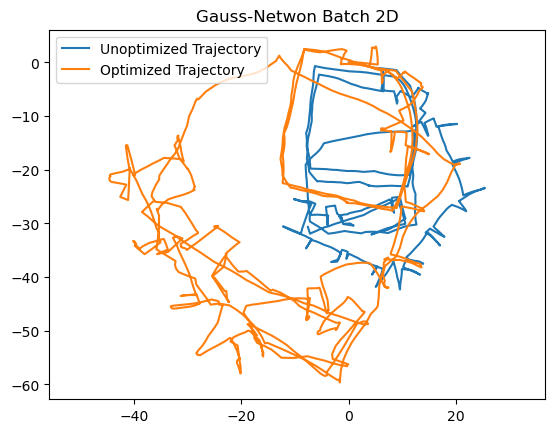

In [29]:
data = read_g2o_2d('data/input_INTEL_g2o.g2o')
init_poses = np.array([[p.x, p.y, p.theta] for p in data['poses']])
opt_poses = gn_2d(data)

plt.plot(init_poses[:,0], init_poses[:,1])
plt.plot(opt_poses[:,0], opt_poses[:,1])
plt.title('Gauss-Netwon Batch 2D')
plt.legend(['Unoptimized Trajectory', 'Optimized Trajectory'])
plt.axis('equal')
plt.show()

### Task 1C. Incremental Solution (20 pts)

Use ISAM2 solver to optimize the
trajectory incrementally (as you build the graph gradually). A
detailed algorithms is described below. Visualize and compare the optimized
trajectory against the initial trajectory.

![isam algorithm](figure/task_1c_algo.png)

**Hint:** You may use `NonlinearFactorGraph` as your graph, use
`gtsam.ISAM2()` as your update algorithm, use `Values` for your
initial estimation, and use `graph.add()`, `initial.insert()`,
`isam.update()`, and `isam.calculateEstimate()` functions as you see
fit. However, function names might be different for different
versions of gtsam.

Expected result for task 1C:

![Expected result for task 1C](figure/isam2d.png)

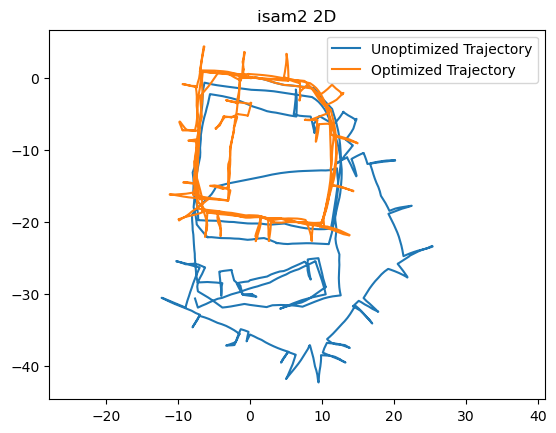

In [30]:
data = read_g2o_2d('data/input_INTEL_g2o.g2o')
init_poses = np.array([[p.x, p.y, p.theta] for p in data['poses']])
opt_poses = isam_2d(data)

plt.plot(init_poses[:,0], init_poses[:,1])
plt.plot(opt_poses[:,0], opt_poses[:,1])
plt.title('isam2 2D')
plt.legend(['Unoptimized Trajectory', 'Optimized Trajectory'])
plt.axis('equal')
plt.show()

## 3D Graph SLAM (50 points)


#### Submission
Please fill the **TODO**s in the function contained in **pose_graph_slam.py** and submit the file to gradescope.

#### Instructions

1. Implement `read_g2o_3d` function (10 points)
2. Implement `gn_3d` function (20 points)
3. Implement `isam_3d` function (20 points)

Your code is evaluated at each step using test input independently. Specifically, during steps 2 and 3, the autograder will use the correct `read_g2o_3d` function to test your code. For example, even if the `read_g2o_3d` function from step 1 is incorrect, implementing `gn_3d` correctly in step 2 can still earn you full credits.

### Task 2A. Reading 3D G2O (10 pts)

Write a function to read [3D Garage G2O file](https://www.dropbox.com/s/zu23p8d522qccor/parking-garage.g2o?dl=0) from G2O
format and output poses and edges. The file we use in task 2 is `data/parking-garage.g2o`.

For 3D data, the pose in G2O format is
`[VERTEX_SE3:QUAT i x y z qx qy qz qw]` where $(x,y,z)$ represents
the translation and $(qx,qy,qz,qw)$ the rotation as a quaternion.
The edge in G2O format is
`[EDGE_SE3:QUAT i j x y z qx qy qz qw info(x, y, z, qx, qy, qz)]`,
where `info(x, y, z, qx, qy, qz)` is a 1 $\times$ 21 vector of the 6
$\times$ 6 information matrix. After similar process in task 1A,
you can obtain the covariance matrix. You may look into detail in
the [g2o repository](https://github.com/RainerKuemmerle/g2o/wiki/File-format-slam-3d).

Please notice that the quaternion in GTSAM is in the order of
`[qw qx qy qz]` and is different from the order in g2o files which
is `[qx qy qz qw]`.


In [31]:
data = read_g2o_3d('data/parking-garage.g2o')

p = data['poses']
e = data['edges']


print('First 3 pose in the dataset:')
for i in range(3):
    print(f'pose {i}: {p[i]}')

print('\nFirst 3 edges in the dataset:')
for i in range(3):
    print(f'edge {i}: {e[i]}')


First 3 pose in the dataset:
pose 0: Pose3(id=0, x=0.0, y=0.0, z=0.0, qx=0.0, qy=0.0, qz=0.0, qw=1.0)
pose 1: Pose3(id=1, x=4.15448, y=-0.0665288, z=0.000389663, qx=-0.0107791, qy=0.00867285, qz=-0.00190021, qw=0.999902)
pose 2: Pose3(id=2, x=8.31419, y=-0.173106, z=-0.0129024, qx=-0.00802114, qy=0.00792915, qz=0.00172397, qw=0.999935)

First 3 edges in the dataset:
edge 0: Edge3(id1=0, id2=1, x=4.15448, y=-0.0665288, z=0.000389663, qx=-0.0107791, qy=0.00867285, qz=-0.00190021, qw=0.999902,
info=
1.00 0.00 0.00 0.00 0.00 0.00
0.00 1.00 0.00 0.00 0.00 0.00
0.00 0.00 1.00 0.00 0.00 0.00
0.00 0.00 0.00 4.00 -0.00 0.07
0.00 0.00 0.00 -0.00 4.00 -0.00
0.00 0.00 0.00 0.07 -0.00 4.00)

edge 1: Edge3(id1=1, id2=2, x=4.15971, y=-0.0912353, z=0.0567356, qx=0.00272799, qy=-0.000777724, qz=0.00363979, qw=0.999989,
info=
1.00 0.00 0.00 0.00 0.00 0.00
0.00 1.00 0.00 0.00 0.00 0.00
0.00 0.00 1.00 0.00 0.00 0.00
0.00 0.00 0.00 4.00 -0.00 -0.01
0.00 0.00 0.00 -0.00 4.00 -0.00
0.00 0.00 0.00 -0.01 -0.00

### Task 2B. Batch Solution (20 pts)

Construct a 3D nonlinear factor graph using GTSAM. Use the
Gauss-Newton solver. Visualize and compare the optimized trajectory
against the initial trajectory.

Expected result for task 2B:

![Expected result for task 2 B.](figure/batch3d.png)

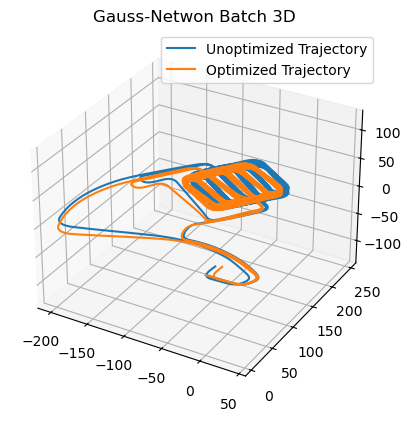

In [32]:
data = read_g2o_3d('data/parking-garage.g2o')
init_poses = np.array([[p.x, p.y, p.z] for p in data['poses']])
opt_poses = gn_3d(data)

ax = plt.axes(projection='3d')
plt.plot(init_poses[:,0],init_poses[:,1],init_poses[:,2])
plt.plot(opt_poses[:,9],opt_poses[:,10],opt_poses[:,11])
plt.title('Gauss-Netwon Batch 3D')
plt.legend(['Unoptimized Trajectory', 'Optimized Trajectory'])

X = opt_poses[:,9]
Y = opt_poses[:,10]
Z = opt_poses[:,11]
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()

### Task 2C. Incremental Solution (20 pts)

Use ISAM2 solver to optimize the
trajectory incrementally. Visualize and compare the optimized
trajectory against the initial trajectory.

Expected result for task 2C:

![Expected result for task 2 C. ](figure/isam3d.png)

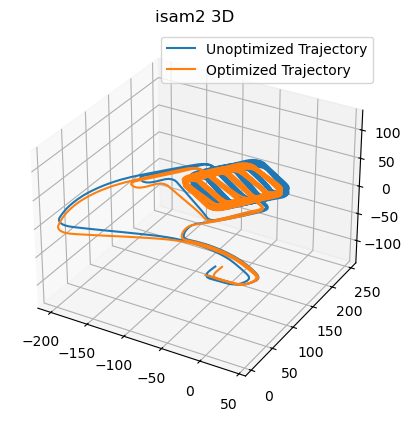

In [34]:
data = read_g2o_3d('data/parking-garage.g2o')
init_poses = np.array([[p.x, p.y, p.z] for p in data['poses']])
opt_poses = isam_3d(data)

ax = plt.axes(projection='3d')
plt.plot(init_poses[:,0],init_poses[:,1],init_poses[:,2])
plt.plot(opt_poses[:,9],opt_poses[:,10],opt_poses[:,11])
plt.title('isam2 3D')
plt.legend(['Unoptimized Trajectory', 'Optimized Trajectory'])

X = opt_poses[:,9]
Y = opt_poses[:,10]
Z = opt_poses[:,11]
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()